In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np

from numpy.fft import fftn, fftshift

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

In [3]:
EPOCHS = 1000
NGPUS = torch.cuda.device_count()
BATCH_SIZE = max(NGPUS,1) * 32
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 1 Batch size: 32 Learning rate: 0.001


### Generate clean and noisy data from a sin()

Text(0.5, 1.0, 'Training data')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


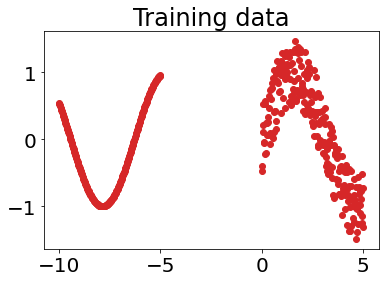

In [4]:
x_train = torch.cat([torch.linspace(-10,-5,250), torch.linspace(0,5,250)]) #Create tensor here and you're good
y_train  = torch.sin(x_train)
noise = np.concatenate([np.zeros(250),np.random.random(x_train[250:].shape)-0.5])
y_train += noise
plt.plot(x_train,y_train,'C3o')
plt.title("Training data")

Text(0.5, 1.0, 'Test data')

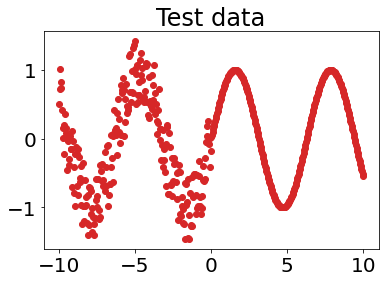

In [5]:
x_test = torch.linspace(-10,10,500) #Create tensor here and you're good
y_test  = torch.sin(x_test)
noise = np.concatenate([np.random.random(x_test[250:].shape)-0.5,np.zeros(250)])
y_test += noise
plt.plot(x_test,y_test,'C3o')
plt.title("Test data")

In [6]:
#Create a TensorDataset and batched loader
train_data = TensorDataset(x_train,y_train)
test_data = TensorDataset(x_test)
N_TRAIN = x_train.shape[0]
N_VALID = 100

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print("Train, valid and test", len(train_data2),len(valid_data),len(test_data))

#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Train, valid and test 400 100 500


In [7]:
class noisy_model(nn.Module):
    def __init__(self):
        super(noisy_model, self).__init__()
        self.D_in = 1 #Input dimension
        self.D_out = 2 #Output dimension -- predict mean and sigma
        self.H = [50,100,150] #Number of neurons in hidden layers

        self.fc = nn.Sequential(
            nn.Linear(self.D_in, self.H[0]), #Input 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[0], self.H[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[1], self.H[2]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.H[2],self.D_out)
        )
    def forward(self,x):
        return self.fc(x)

### Print model summary and move to GPU if available

In [8]:
model = noisy_model()
summary(model,(1,1),device="cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             100
              ReLU-2                [-1, 1, 50]               0
           Dropout-3                [-1, 1, 50]               0
            Linear-4               [-1, 1, 100]           5,100
              ReLU-5               [-1, 1, 100]               0
           Dropout-6               [-1, 1, 100]               0
            Linear-7               [-1, 1, 150]          15,150
              ReLU-8               [-1, 1, 150]               0
           Dropout-9               [-1, 1, 150]               0
           Linear-10                 [-1, 1, 2]             302
Total params: 20,652
Trainable params: 20,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Tot

In [9]:
for x,y in trainloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Trainloader", x.shape,y.shape,y_pred.shape)
    break

for x,y in validloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x.unsqueeze(-1))
    print("Validloader", x.shape,y.shape,y_pred.shape)
    break

Trainloader torch.Size([32]) torch.Size([32]) torch.Size([32, 2])
Validloader torch.Size([32]) torch.Size([32]) torch.Size([32, 2])


In [10]:
#Optimization details
#criterion = nn.L1Loss()
#More robust to predict the log variance (regularizer)
def aleatoric_loss(y_pred, y_true):
    se = (y_true-y_pred[:,0])**2 #First axis are the predicted means
    inv_std = torch.exp(-y_pred[:,1]) #Second axis are the predicted log variance
    mse = torch.mean(inv_std*se) #1/2*exp(-s)*|y-y_pred|**2
    reg = torch.mean(y_pred[:,1]) #1/2*s term
    return 0.5*(mse + reg)

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [11]:
def train(trainloader, metrics):
    tot_loss = 0.0
    for i , (x, y) in enumerate(trainloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = aleatoric_loss (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i]) 


def validate(validloader, metrics):
    tot_loss = 0.0
    for j , (x, y) in enumerate(validloader):
        x = x.to(device) #Move data to approp device
        y = y.to(device)

        y_pred = model(x.unsqueeze(-1)) #Forward pass

        loss = aleatoric_loss (y_pred.squeeze(), y) #Compute loss
        tot_loss += loss.detach().item()
        
    metrics['val_losses'].append([tot_loss/j])


In [12]:
metrics = {'losses':[],'val_losses':[]}#, 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  #model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))

Epoch: 0 | Train Loss: 0.14637 | Val Loss: 0.08789
Epoch: 1 | Train Loss: 0.01743 | Val Loss: 0.22879
Epoch: 2 | Train Loss: -0.02936 | Val Loss: -0.05302
Epoch: 3 | Train Loss: -0.07407 | Val Loss: -0.10708
Epoch: 4 | Train Loss: -0.08724 | Val Loss: -0.10442
Epoch: 5 | Train Loss: -0.17136 | Val Loss: -0.17994
Epoch: 6 | Train Loss: -0.12864 | Val Loss: -0.27356
Epoch: 7 | Train Loss: -0.16100 | Val Loss: -0.25220
Epoch: 8 | Train Loss: -0.20364 | Val Loss: -0.36337
Epoch: 9 | Train Loss: -0.23521 | Val Loss: -0.30500
Epoch: 10 | Train Loss: -0.30143 | Val Loss: -0.40474
Epoch: 11 | Train Loss: -0.22984 | Val Loss: -0.34068
Epoch: 12 | Train Loss: -0.28575 | Val Loss: -0.43003
Epoch: 13 | Train Loss: -0.21145 | Val Loss: -0.32811
Epoch: 14 | Train Loss: -0.26857 | Val Loss: -0.58906
Epoch: 15 | Train Loss: -0.29770 | Val Loss: -0.33495
Epoch: 16 | Train Loss: -0.30361 | Val Loss: -0.36735
Epoch: 17 | Train Loss: -0.27920 | Val Loss: -0.49275
Epoch: 18 | Train Loss: -0.27686 | Val Los

/tmp/ipykernel_685230/2477824602.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


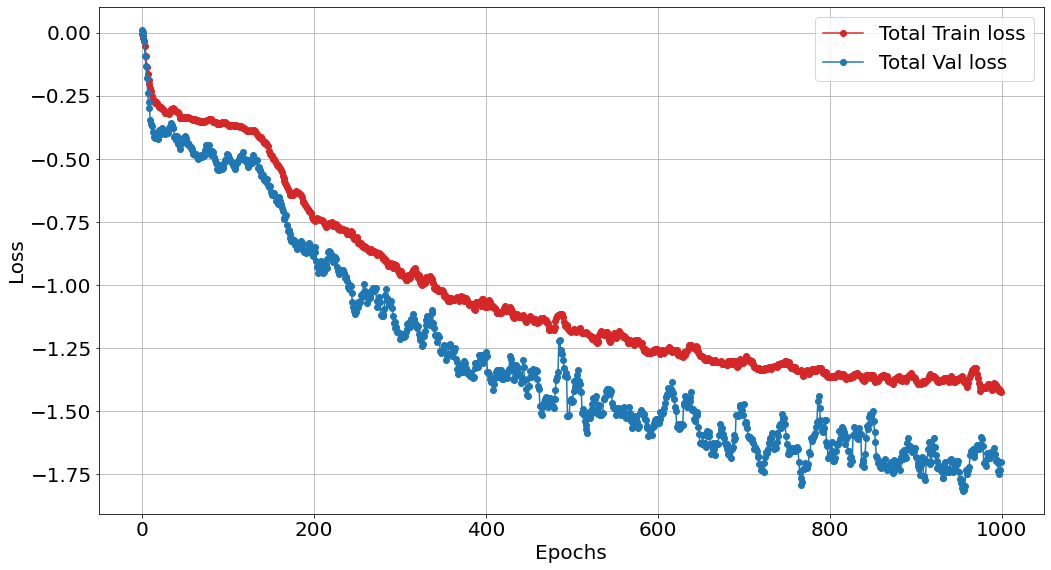

In [13]:
#Thing this is moving average with window of 10
from scipy.ndimage.filters import uniform_filter1d

losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))

smoothed_losses_arr = uniform_filter1d(losses_arr[:,0], size=10)
smoothed_val_losses_arr = uniform_filter1d(val_losses_arr[:,0], size=10)

ax.plot(smoothed_losses_arr, 'C3o-', label = "Total Train loss")
ax.plot(smoothed_val_losses_arr, 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()

plt.tight_layout()
plt.xlabel("Epochs")
plt.legend()

In [14]:
# Evaluate points with trained model
#model.eval()
def model_predict(model, testloader):
    model.train()
    y_preds = []
    for x in testloader:
        x = x[0].to(device)
        evals = model(x.unsqueeze(-1)).squeeze()
        for k in evals:
            y_preds.append(k.detach().to("cpu").numpy())
    y_preds = np.array(y_preds)
    return y_preds

probs = []
for i in tqdm(range(100)):
    probs.append(model_predict(model, testloader))

probs = np.array(probs)
print(probs.shape)


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

(100, 500, 2)


In [15]:
T = 100 #How many samples to draw over data?

In [20]:
train_data = TensorDataset(x_train,y_train)
trainloader_full = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

(100, 500, 2)
(500, 2)


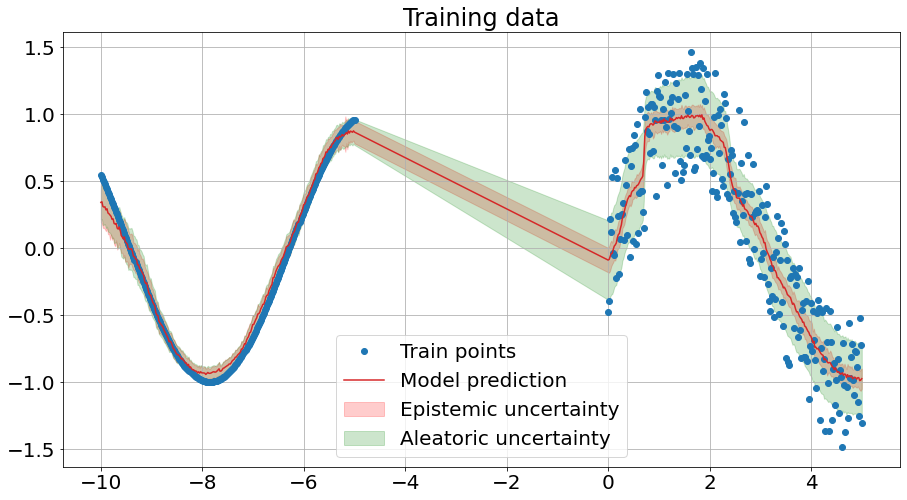

In [22]:
probs = []
for i in tqdm(range(T)):
    probs.append(model_predict(model, trainloader_full))

probs = np.array(probs)
print(probs.shape)

means = np.mean(probs, axis =0)
print(means.shape)

mean_pred = means[:,0] #Take mean (over forward samples) of mean predictions
epistemic_std = np.std(probs, axis=0)[:,0] #Take std over mean predictions
aleatoric_std = np.exp(0.5*means[:,1])#Take mean (over forward samples) of sigmas
#Predicting log-variance so need to exponent

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(x_train,y_train,'C0o', label="Train points")
ax.plot(x_train,mean_pred, 'C3-', label="Model prediction")
ax.fill_between(x_train,mean_pred-epistemic_std, mean_pred+epistemic_std, 
                color='red', alpha=0.2, label="Epistemic uncertainty")
ax.fill_between(x_train,mean_pred-aleatoric_std, mean_pred+aleatoric_std, 
                color='green', alpha=0.2, label="Aleatoric uncertainty")
plt.title("Training data")
ax.grid()
plt.legend()

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

(100, 500, 2)
(500, 2)


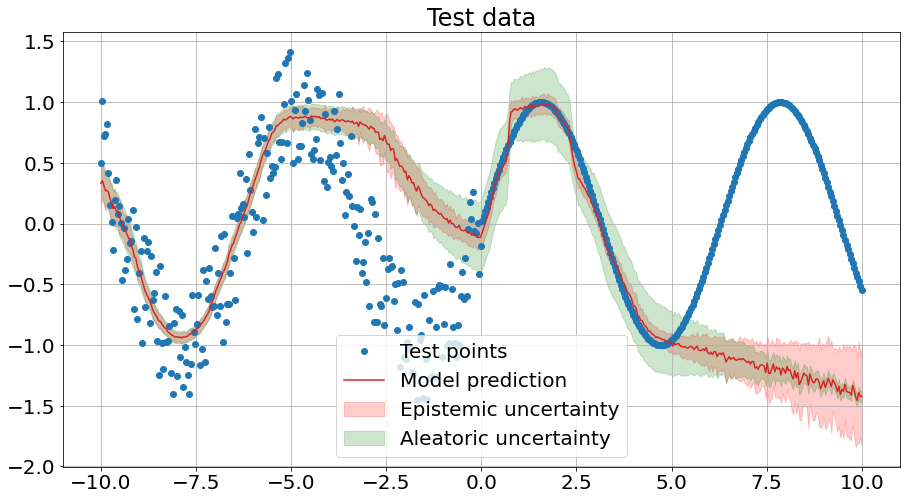

In [17]:
#Eval on test data
probs = []
for i in tqdm(range(T)):
    probs.append(model_predict(model, testloader))

probs = np.array(probs)
print(probs.shape)

means = np.mean(probs, axis =0)
print(means.shape)

mean_pred = means[:,0] #Take mean (over forward samples) of mean predictions
epistemic_std = np.std(probs, axis=0)[:,0] #Take std over mean predictions
aleatoric_std = np.exp(0.5*means[:,1])#Take mean (over forward samples) of sigmas
#Predicting log-variance so need to exponent

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(x_test,y_test,'C0o', label="Test points")
ax.plot(x_test,mean_pred, 'C3-', label="Model prediction")
ax.fill_between(x_test,mean_pred-epistemic_std, mean_pred+epistemic_std, 
                color='red', alpha=0.2, label="Epistemic uncertainty")
ax.fill_between(x_test,mean_pred-aleatoric_std, mean_pred+aleatoric_std, 
                color='green', alpha=0.2, label="Aleatoric uncertainty")
plt.title("Test data")
ax.grid()
plt.legend()